In [133]:
from IPython.display import Javascript

watermark_js = """
var watermark = document.createElement('div');
watermark.textContent = "© Dushyant Singh Hada";
watermark.style.position = 'fixed';
watermark.style.bottom = '10px';
watermark.style.right = '10px';
watermark.style.opacity = '0.3';
watermark.style.fontSize = '14px';
watermark.style.color = 'gray';
document.body.appendChild(watermark);
"""
display(Javascript(watermark_js))


<IPython.core.display.Javascript object>

import libraries

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Add a consistent, clean plotting theme for all cells
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'figure.dpi': 120
})

important functions

In [135]:
import math

def wilson(x1, v1, v2, a12, a21, temp):
    # Bound x1 to avoid log(0)
    x1 = min(max(x1, 1e-12), 1-1e-12)
    x2 = 1 - x1
    
    delta12 = (v2/v1)*math.exp(-a12/(8.314*temp))
    delta21 = (v1/v2)*math.exp(-a21/(8.314*temp))

    ln_gamma1 = -math.log(x1 + x2*delta12) + x2*((delta12/(x1 + x2*delta12)) - (delta21/(x2 + x1*delta21)))
    ln_gamma2 = -math.log(x2 + x1*delta21) - x1*((delta12/(x1 + x2*delta12)) - (delta21/(x2 + x1*delta21)))

    return math.exp(ln_gamma1), math.exp(ln_gamma2)


def nrtl(x1, b12, b21, alpha, temp):
    # Bound x1
    x1 = min(max(x1, 1e-12), 1-1e-12)
    x2 = 1 - x1

    tau12 = b12/(8.314*temp)
    tau21 = b21/(8.314*temp)

    g12 = math.exp(-alpha * tau12)
    g21 = math.exp(-alpha * tau21)

    # Correct NRTL equations
    ln_gamma1 = x2**2 * (tau21 * (g21 / (x1 + x2*g21))**2 + (g12 * tau12) / (x2 + x1*g12)**2)
    ln_gamma2 = x1**2 * (tau12 * (g12 / (x2 + x1*g12))**2 + (g21 * tau21) / (x1 + x2*g21)**2)

    return math.exp(ln_gamma1), math.exp(ln_gamma2)


def vap_pressure(A, B, C, temp):
    # Antoine expects Celsius
    T_C = temp - 273.15
    ln_psat = A - B / (T_C + C)
    return math.exp(ln_psat)


def boiling_pt(A, B, C, psat):
    # returns Kelvin
    T_C = B / (A - math.log(psat)) - C
    return T_C + 273.15


# Small helper for nicer console output of DataFrames
def pretty_print_df(df, n=10):
    """Print a rounded preview of a dataframe for clarity."""
    print('\n--- Data (first {} rows) ---'.format(n))
    print(df.round(4).head(n).to_string(index=False))


initializing data

In [136]:
component1 = "comp1"
component2 = "comp2"
print(f"Components: {component1}, {component2}")
required = ["v1","v2","a12","a21","b12","b21","alpha", "A1","B1","C1","A2","B2","C2"]
values = {}
# for i in required:
#     values[i] = float(input(f"enter value of {i} for your components"))


values = {
    'v1': 74.05*1e-3, 
    'v2': 18.07*1e-3, 
    'a12': 1219.5, 
    'a21': 6062.5,
    'b12': 2642.1, 
    'b21': 5013.3, 
    'alpha': 0.5343,
    'A1': 14.3154,  
    'B1': 2756.22, 
    'C1': 228.06, 
    'A2': 16.3872, 
    'B2': 3885.7,
    'C2': 230.17
}

print('\nValues dictionary summary:')
for k, v in values.items():
    if isinstance(v, float):
        print(f"  {k:5s}: {v:.6g}")
    else:
        print(f"  {k:5s}: {v}")

Components: comp1, comp2

Values dictionary summary:
  v1   : 0.07405
  v2   : 0.01807
  a12  : 1219.5
  a21  : 6062.5
  b12  : 2642.1
  b21  : 5013.3
  alpha: 0.5343
  A1   : 14.3154
  B1   : 2756.22
  C1   : 228.06
  A2   : 16.3872
  B2   : 3885.7
  C2   : 230.17


12.12

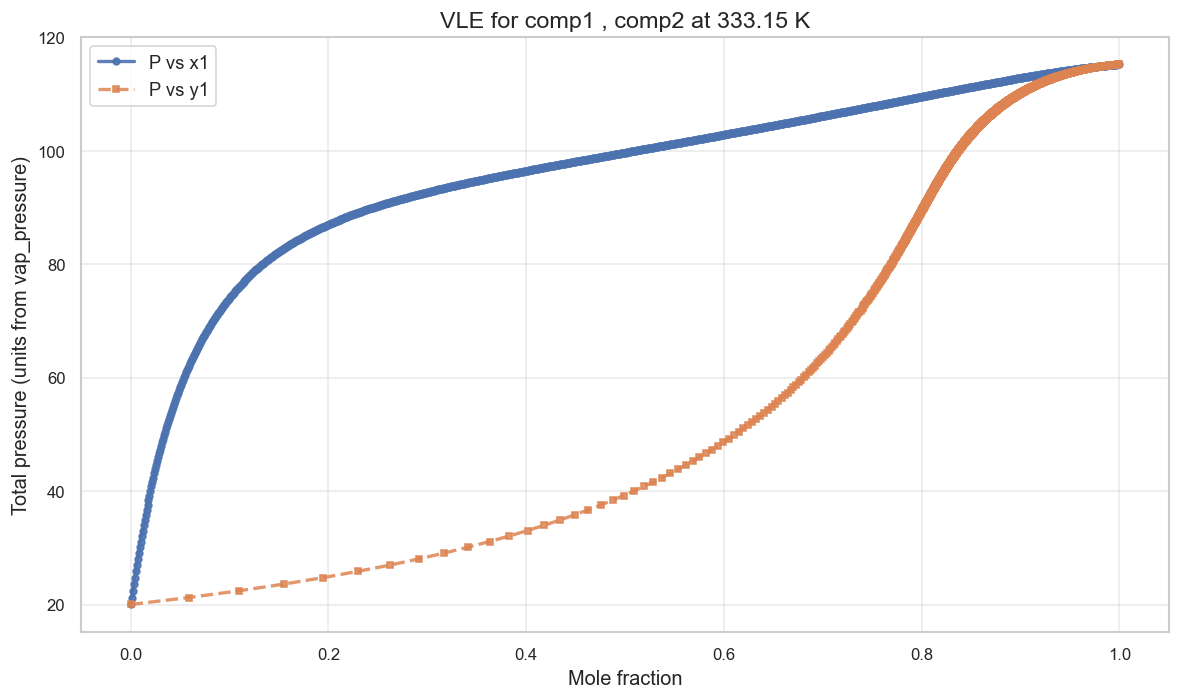


--- Data (first 10 rows) ---
   x1     y1  pressure
0.000 0.0000   20.0070
0.001 0.0587   21.2339
0.002 0.1099   22.4327
0.003 0.1549   23.6043
0.004 0.1948   24.7496
0.005 0.2304   25.8692
0.006 0.2623   26.9640
0.007 0.2912   28.0345
0.008 0.3173   29.0816
0.009 0.3411   30.1059


In [137]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[0] for x in x1]
gamma2 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure()
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1', alpha=0.9, markersize=4)
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1', alpha=0.85, markersize=4)
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (units from vap_pressure)')
plt.title(f'VLE for {component1} , {component2} at {temp:.2f} K')
plt.grid(True, alpha=0.4)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

pretty_print_df(result)

12.13

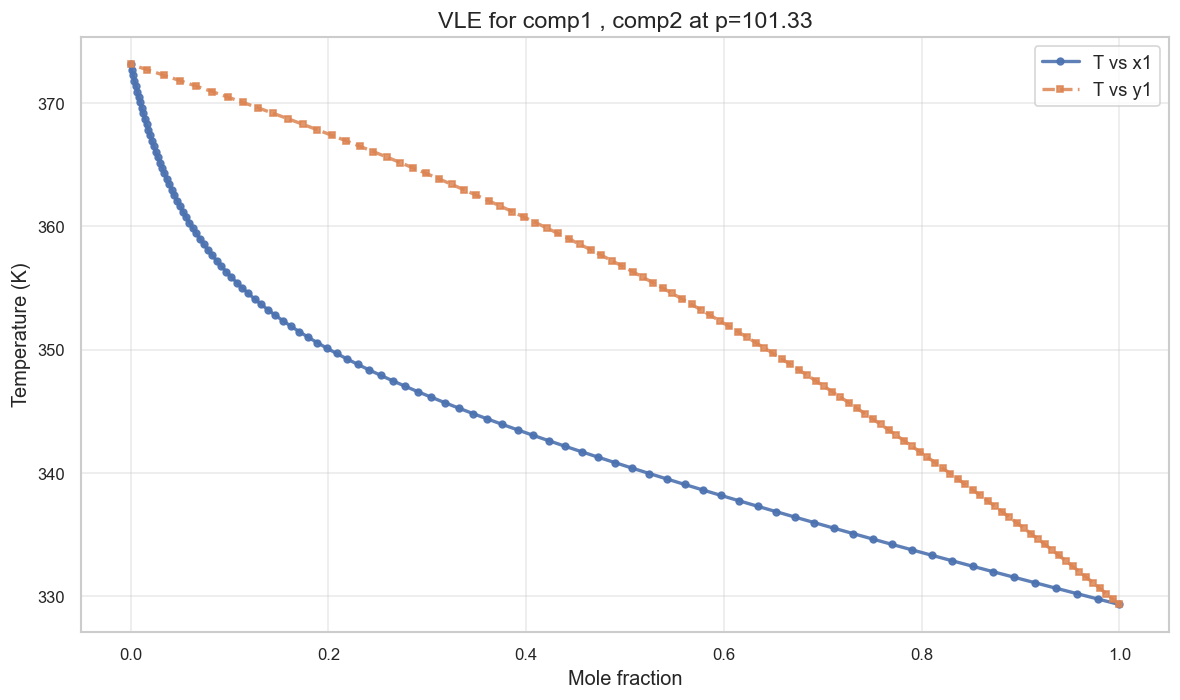


--- Data (first 10 rows) ---
    x1     y1  temperature
1.0000 1.0000     329.3238
0.9784 0.9934     329.7665
0.9569 0.9867     330.2091
0.9356 0.9800     330.6518
0.9144 0.9733     331.0945
0.8934 0.9665     331.5372
0.8725 0.9597     331.9799
0.8518 0.9528     332.4225
0.8312 0.9458     332.8652
0.8108 0.9389     333.3079


In [138]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure()
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1', alpha=0.9, markersize=4)
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1', alpha=0.85, markersize=4)
plt.xlabel('Mole fraction')
plt.ylabel('Temperature (K)')
plt.title(f'VLE for {component1} , {component2} at p={p:.2f}')
plt.grid(True, alpha=0.4)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
pretty_print_df(result)

12.14

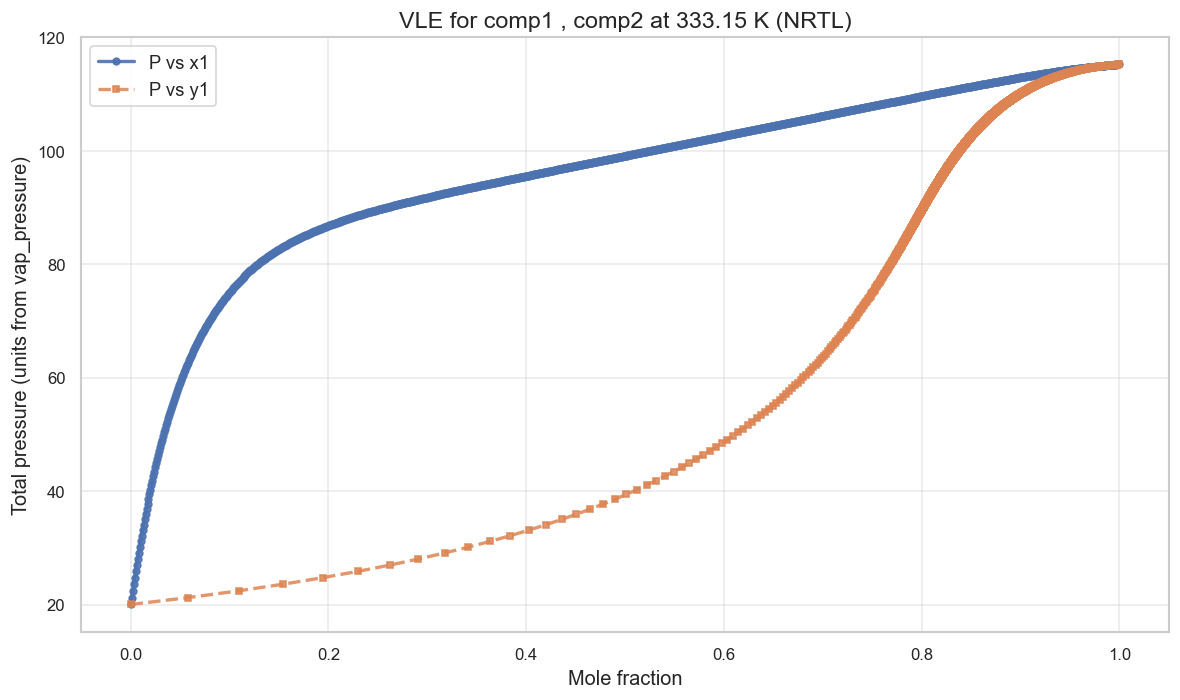


--- Data (first 10 rows) ---
   x1     y1  pressure
0.000 0.0000   20.0070
0.001 0.0583   21.2248
0.002 0.1093   22.4177
0.003 0.1543   23.5865
0.004 0.1942   24.7317
0.005 0.2299   25.8538
0.006 0.2620   26.9533
0.007 0.2911   28.0308
0.008 0.3175   29.0868
0.009 0.3415   30.1218


In [139]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[0] for x in x1]
gamma2 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure()
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1', alpha=0.9, markersize=4)
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1', alpha=0.85, markersize=4)
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (units from vap_pressure)')
plt.title(f'VLE for {component1} , {component2} at {temp:.2f} K (NRTL)')
plt.grid(True, alpha=0.4)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
pretty_print_df(result)

12.15

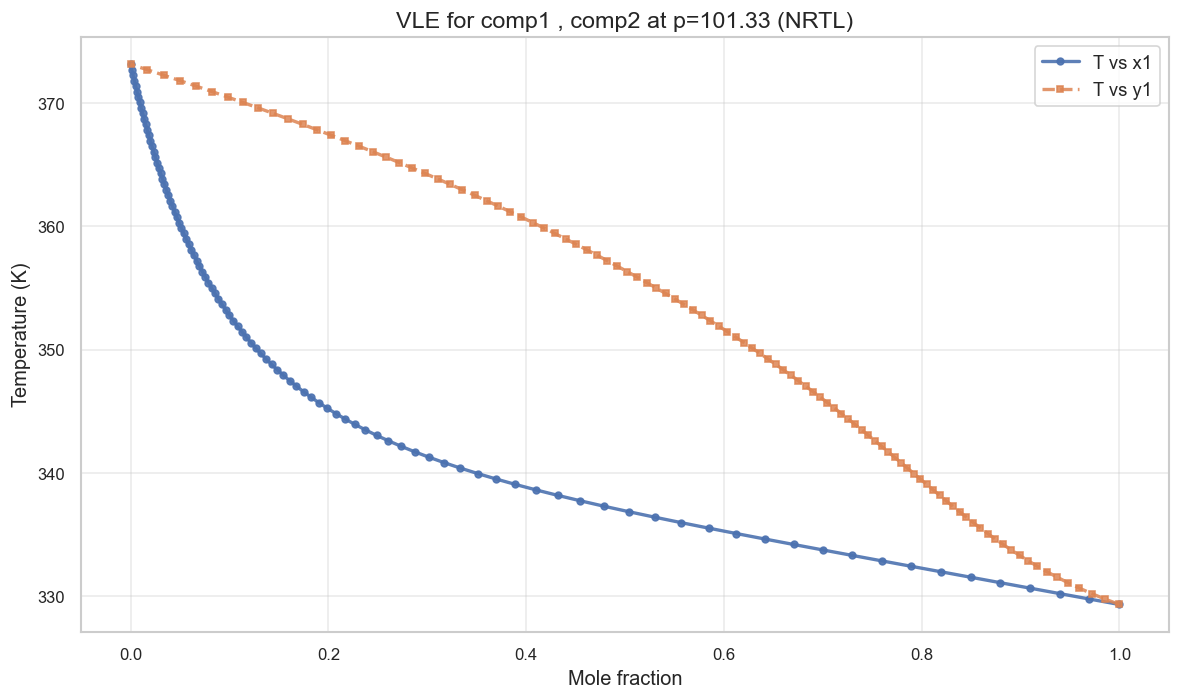


--- Data (first 10 rows) ---
    x1     y1  temperature
1.0000 1.0000     329.3238
0.9697 0.9854     329.7665
0.9396 0.9720     330.2091
0.9096 0.9596     330.6518
0.8795 0.9480     331.0945
0.8495 0.9371     331.5372
0.8195 0.9268     331.9799
0.7895 0.9171     332.4225
0.7596 0.9079     332.8652
0.7297 0.8991     333.3079


In [140]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure()
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1', alpha=0.9, markersize=4)
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1', alpha=0.85, markersize=4)
plt.xlabel('Mole fraction')
plt.ylabel('Temperature (K)')
plt.title(f'VLE for {component1} , {component2} at p={p:.2f} (NRTL)')
plt.grid(True, alpha=0.4)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
pretty_print_df(result)

12.16

(a) bubble pressure: 92.7109 (units from vap_pressure)
(b) dew pressure: 28.3803 (units from vap_pressure)
(c) flash vapor fraction (approx): 0.3904


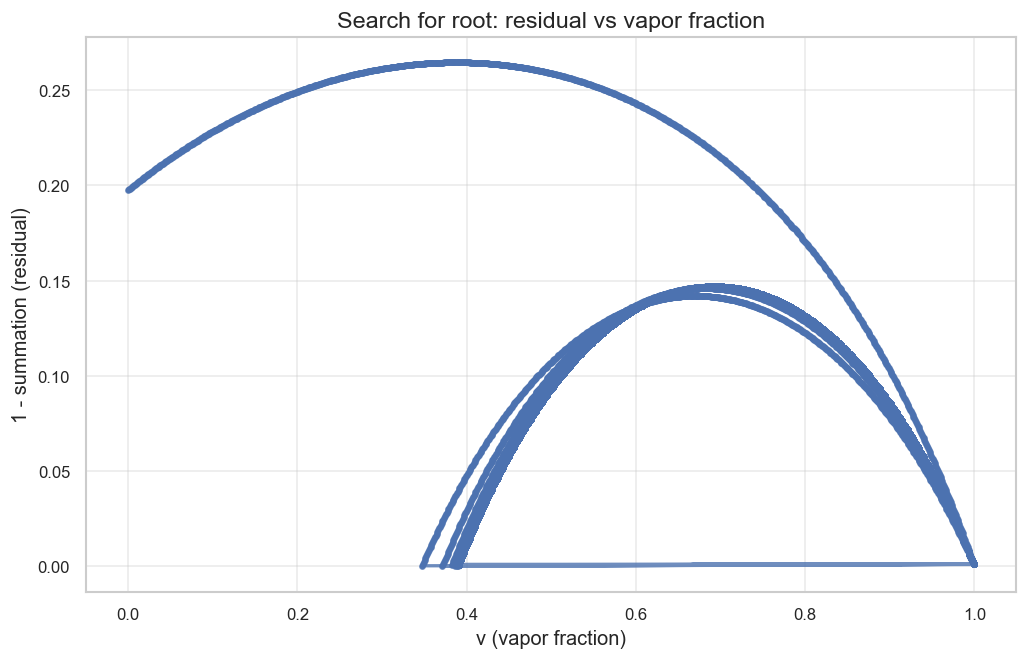

(d) azeotrope not detected in the scanned range for given T/P.


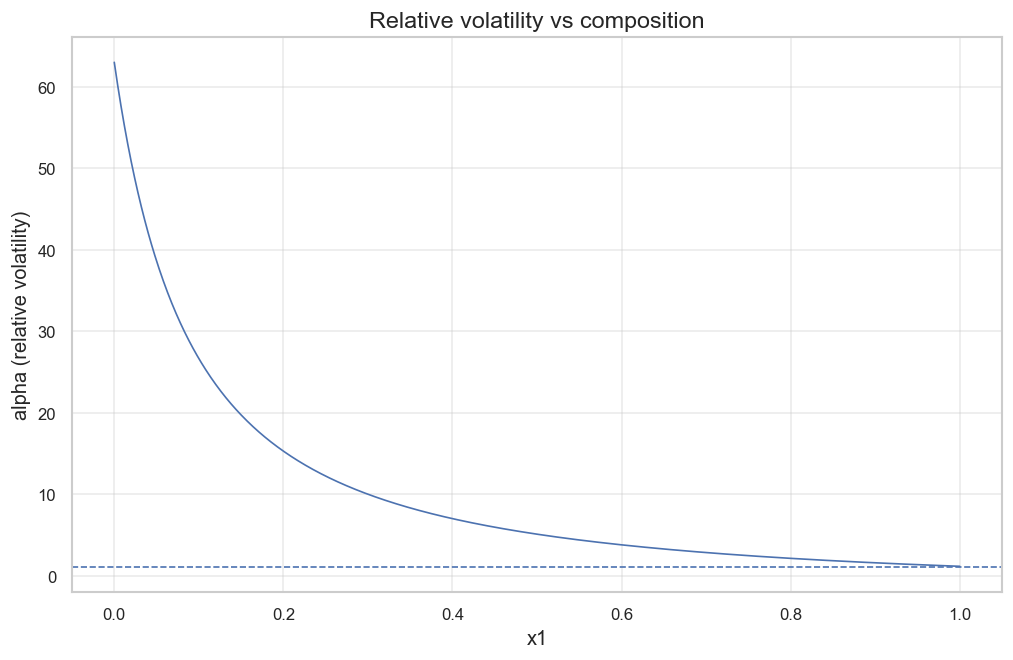

In [141]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2
print(f"(a) bubble pressure: {pb:.6g} (units from vap_pressure)")

# (b)
y1 = 0.3
for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
print(f"(b) dew pressure: {p_dew:.6g} (units from vap_pressure)")

# (c)
t_flash = 333.15
p_flash = (pb + p_dew) / 2
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
z1 = 0.3
v_value = []
summa = []

for i in range(100):
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], t_flash) if i!=0 else (1,1)
    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    prev = float("inf")
    for v in np.linspace(0,1,1000):
        if v==1:
            continue
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            ans_v = v
print(f"(c) flash vapor fraction (approx): {ans_v:.4f}")
plt.figure()
plt.plot(v_value, summa, marker='.', alpha=0.8)
plt.scatter(v_value, summa, s=10, alpha=0.6)
plt.xlabel('v (vapor fraction)')
plt.ylabel('1 - summation (residual)')
plt.title('Search for root: residual vs vapor fraction')
plt.grid(True, alpha=0.4)
plt.show()

# (d)
x_vals = []
def alpha_func(x1,p1sat,p2sat):
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
    return gamma1*p1sat/(gamma2*p2sat)

x_vals, alpha_vals = [], []
for x in np.linspace(0,1,1000):
    alpha = alpha_func(x,p1sat,p2sat)
    x_vals.append(x)
    alpha_vals.append(alpha)

if alpha_vals[0]*alpha_vals[-1] < 0:
    # crude bracket found
    print("(d) azeotrope formation takes place within the composition range (approx).")
else:
    print("(d) azeotrope not detected in the scanned range for given T/P.")
plt.figure()
plt.plot(x_vals, alpha_vals, lw=1)
plt.axhline(y=1, linestyle='--', linewidth=1)
plt.xlabel('x1')
plt.ylabel('alpha (relative volatility)')
plt.title('Relative volatility vs composition')
plt.grid(True, alpha=0.4)
plt.show()

12.17

In [142]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2
print(f"(a) bubble pressure (NRTL): {pb:.6g} (units from vap_pressure)")

# (b)
y1 = 0.3
for i in range(100):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
print(f"(b) dew pressure (NRTL): {p_dew:.6g} (units from vap_pressure)")

# (c) & plotting similar approach — results printed/visualized above in previous cells

(a) bubble pressure (NRTL): 91.796 (units from vap_pressure)
(b) dew pressure (NRTL): 28.3795 (units from vap_pressure)


12.18

In [143]:
p = 101.33
# (a) iterative bubble temp (Wilson)
x1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
tb = temp
print(f"(a) bubble temperature (Wilson): {temp:.3f} K")

# (b) iterative dew temp
y1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x2 = 1-x1

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
td = temp
print(f"(b) dew temperature (Wilson): {temp:.3f} K")

(a) bubble temperature (Wilson): 322.938 K
(b) dew temperature (Wilson): 363.748 K


12.19

In [144]:
p = 101.33
# (a) using NRTL: iterative bubble temp
x1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
tb = temp
print(f"(a) bubble temperature (NRTL): {temp:.3f} K")

# (b) dew via NRTL
y1 = 0.3
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
    x1 = y1*p_dew/(p1sat*gamma1)

    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
td = temp
print(f"(b) dew temperature (NRTL): {temp:.3f} K")

(a) bubble temperature (NRTL): 322.274 K
(b) dew temperature (NRTL): 363.763 K


functions for ternery system

In [145]:
import math

def wilson_ternary(x, v, a, temp):
    """
    Wilson model for 3-component system
    """
    x = [max(min(xi, 1 - 1e-12), 1e-12) for xi in x]
    R = 8.314
    Lambda = [[0.0]*3 for _ in range(3)]
    for i in range(3):
        for j in range(3):
            if i != j:
                Lambda[i][j] = (v[j]/v[i]) * math.exp(-a[i][j]/(R*temp))
            else:
                Lambda[i][j] = 1.0
    ln_gamma = [0.0]*3
    for i in range(3):
        sum1 = sum(x[j] * Lambda[i][j] for j in range(3))
        term1 = 1 - math.log(sum1)
        term2 = 0
        for j in range(3):
            sum2 = sum(x[k] * Lambda[j][k] for k in range(3))
            term2 += x[j] * (Lambda[j][i] / sum2)
        ln_gamma[i] = term1 - term2
    gamma = [math.exp(val) for val in ln_gamma]
    return gamma

def nrtl_ternary(x, b, alpha, temp):
    R = 8.314
    n = 3
    x = [max(min(xi, 1 - 1e-12), 1e-12) for xi in x]
    tau = [[0]*n for _ in range(n)]
    G = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                tau[i][j] = b[i][j] / (R * temp)
                G[i][j] = math.exp(-alpha[i][j] * tau[i][j])
            else:
                tau[i][j] = 0
                G[i][j] = 1
    ln_gamma = [0.0]*n
    for i in range(n):
        sum1 = 0.0
        sum2 = 0.0
        denom_i = sum(x[k] * G[k][i] for k in range(n))
        for j in range(n):
            denom_j = sum(x[k] * G[k][j] for k in range(n))
            term1 = (x[j] * tau[j][i] * G[j][i]) / denom_i
            term2 = (x[j] * G[i][j]) / denom_j * (tau[i][j] - sum(x[m] * tau[m][j] * G[m][j] for m in range(n)) / denom_j)
            sum1 += term1
            sum2 += term2
        ln_gamma[i] = sum1 + sum2
    gamma = [math.exp(val) for val in ln_gamma]
    return gamma

data for ternary questions

In [146]:
'''
1 is acetone
2 is methanol
3 is water
'''
a_ij = [[None,-677.8,1219.5],
       [2441.4,None,449.6],
       [6062.5,1965.9,None]]

b_ij = [[None,773.3,2642.1],
        [932.1,None,-1062.9],
        [5013.3,3538.7,None]]

alpha_ij = [[None,0.3084,0.5343],
            [0.3084,None,0.2994],
            [0.5343,0.2994,None]]

v1,v2,v3 = 74.05*1e-3, 40.73*1e-3, 18.07*1e-3

A1,B1,C1 = 14.3145, 2756.22, 228.060
A2,B2,C2 = 16.5785, 3638.27, 239.500
A3,B3,C3 = 16.3872, 3885.7, 230.170

12.20

In [147]:
# (a)
temp = 338.15
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

gamma1,gamma2,gamma3 = wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp)
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)
pb = x1*gamma1*p1sat + x2*p2sat*gamma2 + x3*p3sat*gamma3
print(f"(a) ternary bubble pressure at T={temp:.2f} K: {pb:.6g} (units from vap_pressure)")

# (b) dew
y1 = 0.3
y2 = 0.4
y3 = 1-y2-y1
for i in range(10):
       gamma1, gamma2,gamma3 = wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp) if i!=0 else (1,1,1)
       p_dew = 1/(y1/(gamma1*p1sat) + y2/(gamma2*p2sat) + y3/(gamma3*p3sat))
       x1 = (y1*p_dew)/(p1sat*gamma1)
       x2 = (y2*p_dew)/(p2sat*gamma2)
       x3 = 1-x1-x2
print(f"(b) ternary dew pressure at T={temp:.2f} K: {p_dew:.6g} (units from vap_pressure)")

(a) ternary bubble pressure at T=338.15 K: 117.121 (units from vap_pressure)
(b) ternary dew pressure at T=338.15 K: 69.1377 (units from vap_pressure)

(b) ternary dew pressure at T=338.15 K: 69.1377 (units from vap_pressure)


12.21

In [148]:
# (a)
temp = 338.15
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

gamma1,gamma2,gamma3 = nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp)
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)
pb = x1*gamma1*p1sat + x2*p2sat*gamma2 + x3*p3sat*gamma3
print(f"(a) ternary bubble pressure (NRTL) at T={temp:.2f} K: {pb:.6g}")

# (b) dew
y1 = 0.3
y2 = 0.4
y3 = 1-y2-y1
for i in range(10):
       gamma1, gamma2,gamma3 = nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp) if i!=0 else (1,1,1)
       p_dew = 1/(y1/(gamma1*p1sat) + y2/(gamma2*p2sat) + y3/(gamma3*p3sat))
       x1 = (y1*p_dew)/(p1sat*gamma1)
       x2 = (y2*p_dew)/(p2sat*gamma2)
       x3 = 1-x1-x2
print(f"(b) ternary dew pressure (NRTL) at T={temp:.2f} K: {p_dew:.6g}")

(a) ternary bubble pressure (NRTL) at T=338.15 K: 115.318
(b) ternary dew pressure (NRTL) at T=338.15 K: 68.949


12.22

In [149]:
p = 101.33
# (a) ternary bubble temperature (Wilson)
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

t1sat = boiling_pt(A1,B1,C1, p)
t2sat = boiling_pt(A2,B2,C2, p)
t3sat = boiling_pt(A3,B3,C3, p)
t_avg =(t1sat+t2sat+t3sat)/3

temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

    gamma1, gamma2,gamma3 =  wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(A1,B1,C1, p1sat)
tb = temp
print(f"(a) ternary bubble temperature (Wilson): {temp:.3f} K")

# (b) ternary dew temperature — iterative
y1 = 0.3
y2=0.4
y3=1-y1-y2
temp = (t1sat+t2sat+t3sat)/3
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (y2)/(gamma2*p2sat) + (y3)/(gamma3*p3sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x3 = y3*p_dew/(p3sat*gamma3)
    x2 = 1-x1-x3

    gamma1, gamma2,gamma3 =  wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(A1, B1, C1, p1sat)
td = temp
print(f"(b) ternary dew temperature (Wilson): {temp:.3f} K")

(a) ternary bubble temperature (Wilson): 328.758 K
(b) ternary dew temperature (Wilson): 320.447 K


12.23

In [150]:
p = 101.33
# (a) ternary bubble temperature (NRTL)
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

t1sat = boiling_pt(A1,B1,C1, p)
t2sat = boiling_pt(A2,B2,C2, p)
t3sat = boiling_pt(A3,B3,C3, p)
t_avg =(t1sat+t2sat+t3sat)/3

temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

    gamma1, gamma2,gamma3 =  nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(A1,B1,C1, p1sat)
tb = temp
print(f"(a) ternary bubble temperature (NRTL): {temp:.3f} K")

# (b) dew iterative (NRTL)
y1 = 0.3
y2=0.4
y3=1-y1-y2
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (y2)/(gamma2*p2sat) + (y3)/(gamma3*p3sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x3 = y3*p_dew/(p3sat*gamma3)
    x2 = 1-x1-x3

    gamma1, gamma2,gamma3 =  nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(A1, B1, C1, p1sat)
td = temp
print(f"(b) ternary dew temperature (NRTL): {temp:.3f} K")

(a) ternary bubble temperature (NRTL): 328.226 K
(b) ternary dew temperature (NRTL): 321.436 K
